In [1752]:
### IMPORTS ###
import os
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter

In [1753]:
### SETTINGS ###
np.set_printoptions(precision=3, suppress=True, threshold=np.inf)

In [1754]:
### FOLDER SETTINGS ###
input_folder = "../output/"

u_solution_path = input_folder + "/u_solution.dat"
v_solution_path = input_folder + "/v_solution.dat"
p_solution_path = input_folder + "/p_solution.dat"
vel_div_path = input_folder + "/vel_div.dat"

In [1755]:
format_string = '<d'  # '<d' for little-endian, '>d' for big-endian

In [1756]:
with open(u_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    u_approximate_solution = data

with open(v_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    v_approximate_solution = data

with open(p_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    p_approximate_solution = data

with open(vel_div_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    vel_div = data

u_approximate_solution = np.array(u_approximate_solution)    
v_approximate_solution = np.array(v_approximate_solution)
p_approximate_solution = np.array(p_approximate_solution)
vel_div = np.array(vel_div)

In [1757]:
### PARAMETERS ###

# Grid parameters
ndims = 2
num_data_per_elements = 1

x_grid = 32
sigma_grid = 32

x_ghost_points = 0
sigma_ghost_points = 0

# Physical parameters
g = 9.81

Lx = 1.0
Ls = 1.0

t = 0
kh = 1.0
lwave = Lx
kwave = 2 * np.pi / lwave
hd = kh/kwave
cwave = np.sqrt(g/kwave*np.tanh(kh))
Twave = lwave/cwave
wwave = 2 * np.pi / Twave
Hwave = 0.02

# Lx,Ls
domain_begin_array = np.array([0.0, 0.0])
domain_end_array = np.array([Lx, Ls])

In [1758]:
u_layout = (sigma_grid, x_grid+x_ghost_points, num_data_per_elements)
v_layout = (sigma_grid, x_grid+x_ghost_points, num_data_per_elements)
p_layout = (sigma_grid+sigma_ghost_points, x_grid+x_ghost_points, num_data_per_elements)

print("u_layout: ", u_layout)
print("v_layout: ", v_layout)
print("p_layout: ", p_layout)

u_layout:  (32, 32, 1)
v_layout:  (32, 32, 1)
p_layout:  (32, 32, 1)


In [1759]:
x = np.linspace(domain_begin_array[0], domain_end_array[0], x_grid)
sigma = np.linspace(domain_begin_array[1], domain_end_array[1], sigma_grid)

X, SIGMA = np.meshgrid(x, sigma)

In [1760]:
# Reshape the data into a 2D array
u_approximate_solution = u_approximate_solution.reshape(u_layout)
v_approximate_solution = v_approximate_solution.reshape(v_layout)
p_approximate_solution = p_approximate_solution.reshape(p_layout)
vel_div = vel_div.reshape(p_layout)

u_approximate_solution = np.squeeze(u_approximate_solution)
v_approximate_solution = np.squeeze(v_approximate_solution)
p_approximate_solution = np.squeeze(p_approximate_solution)
vel_div = np.squeeze(vel_div)

#u_approximate_solution = u_approximate_solution[0:sigma_grid, 1:x_grid+1]
#v_approximate_solution = v_approximate_solution[0:sigma_grid, 1:x_grid+1]
#p_approximate_solution = p_approximate_solution[1:sigma_grid+1, 1:x_grid+1]

u_approximate_solution = u_approximate_solution.T
v_approximate_solution = v_approximate_solution.T
p_approximate_solution = p_approximate_solution.T
vel_div = vel_div.T

print("u_approximate_solution.shape: ", u_approximate_solution.shape)
print("v_approximate_solution.shape: ", v_approximate_solution.shape)
print("p_approximate_solution.shape: ", p_approximate_solution.shape)
print("vel_div.shape: ", vel_div.shape)

u_approximate_solution.shape:  (32, 32)
v_approximate_solution.shape:  (32, 32)
p_approximate_solution.shape:  (32, 32)
vel_div.shape:  (32, 32)


In [1761]:
def traveling_wave_1d(H, c, k, sigma, h_small, w, t, x):

    z = sigma*h_small - h_small

    # Compute analytical solution at level z
    uu = k * H * c / 2 * np.cosh(k * (z + h_small)) / np.sinh(k * h_small) * np.cos(w * t - k * x)
    uu_x = -k**2 * H * c / 2 * np.cosh(k * (z + h_small)) / np.sinh(k * h_small) * np.sin(w * t - k * x)

    ww = -k * H * c / 2 * np.sinh(k * (z + h_small)) / np.sinh(k * h_small) * np.sin(w * t - k * x)
    ww_z = -k**2 * H * c / 2 * np.cosh(k * (z + h_small)) / np.sinh(k * h_small) * np.sin(w * t - k * x)
    
    eta = H / 2 * np.cos(w * t - k * x)  # z = 0
    etax = k * H / 2 * np.sin(w * t - k * x)
    etaxx = -(k**2) * H / 2 * np.cos(w * t - k * x)
    
    pp = -H * c / 2 * np.cosh(k * (z + h_small)) / np.sinh(k * h_small) * np.sin(w * t - k * x)  # see p. 83 in Svendsen & Jonsson (2001)
    
    return uu, uu_x, ww, ww_z, eta, etax, etaxx, pp

In [1762]:
# Plotting each component at t = 0
t = 0
uu, uu_x, ww, ww_z, eta, etax, etaxx, pp = traveling_wave_1d(Hwave, cwave, kwave, SIGMA, hd, wwave, t, X)
vel_div_analytical = uu_x + ww_z

In [1763]:
# Calculate the max error of the pressure
max_uu_error = np.max(np.abs(u_approximate_solution - uu))
max_ww_error = np.max(np.abs(v_approximate_solution - ww))
max_vel_div_error = np.max(np.abs(vel_div - vel_div_analytical))
max_pp_error = np.max(np.abs(p_approximate_solution - pp))

# Calculate the L2 error of the pressure
l2_uu_error = np.linalg.norm(u_approximate_solution - uu, 2)/(sigma_grid*x_grid)
l2_ww_error = np.linalg.norm(v_approximate_solution - ww, 2)/(sigma_grid*x_grid)
l2_vel_div_error = np.linalg.norm(vel_div - vel_div_analytical, 2)/(sigma_grid*x_grid)
l2_pp_error = np.linalg.norm(p_approximate_solution - pp, 2)/(sigma_grid*x_grid)

In [1764]:
# N, S, E
# 8x8, 3, 1.941e-02
# 16x16, 3, 5.078e-03
# 32x32, 3, 1.310e-03
# 64x64, 3, 3.328e-04
# 128x128, 3, 8.384e-05

# 8x8, 5, 3.896e-01
# 16x16, 5, 1.390e-02
# 32x32, 5, 1.284e-03
# 64x64, 5, 3.261e-04
# 128x128, 5, 8.199e-05

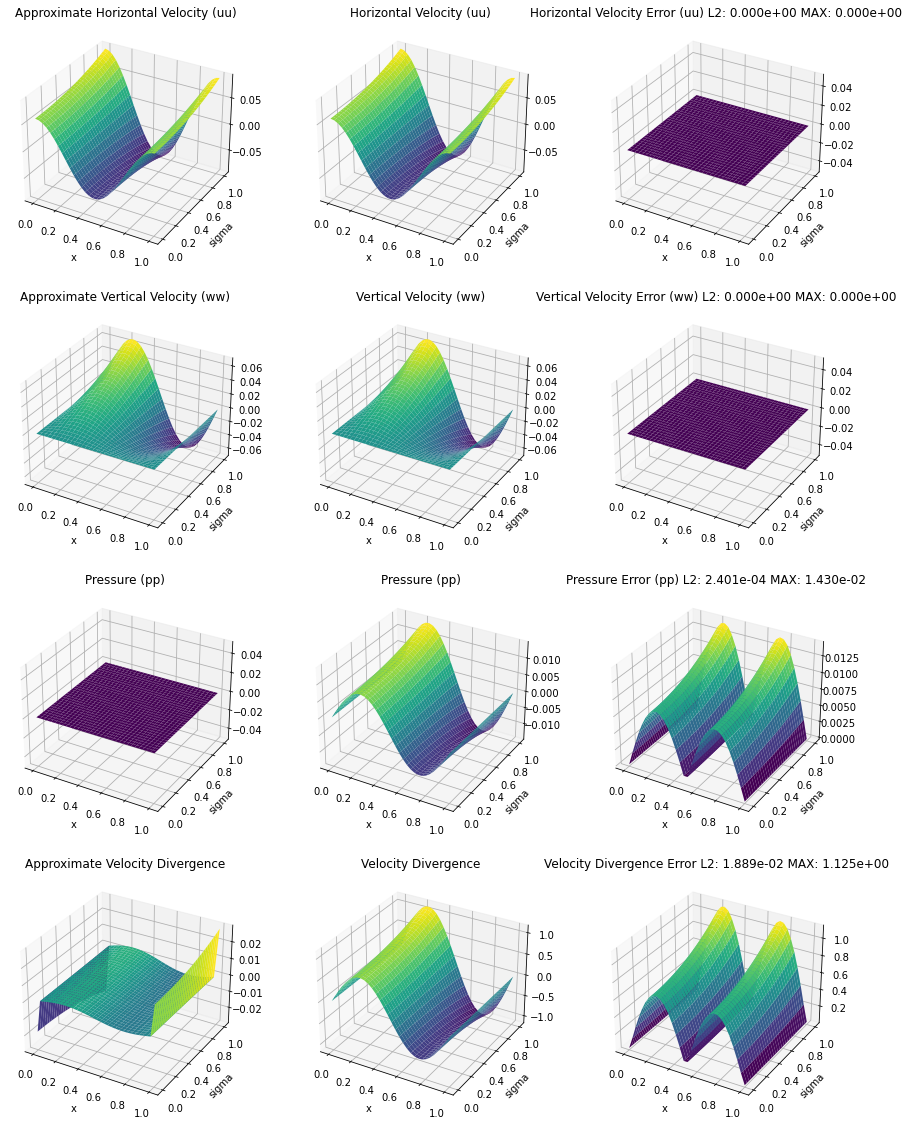

In [1765]:
# Create the figure for 3D surface plots
fig = plt.figure(figsize=(15, 20))

# First Row: uu plots
# Plot Approximate Horizontal Velocity (uu)
ax1 = fig.add_subplot(4, 3, 1, projection='3d')
ax1.plot_surface(X, SIGMA, u_approximate_solution, cmap='viridis')
ax1.set_title('Approximate Horizontal Velocity (uu)')
ax1.set_xlabel('x')
ax1.set_ylabel('sigma')

# Plot Horizontal Velocity (uu)
ax2 = fig.add_subplot(4, 3, 2, projection='3d')
ax2.plot_surface(X, SIGMA, uu, cmap='viridis')
ax2.set_title('Horizontal Velocity (uu)')
ax2.set_xlabel('x')
ax2.set_ylabel('sigma')

# Plot Horizontal Velocity Error
ax3 = fig.add_subplot(4, 3, 3, projection='3d')
ax3.plot_surface(X, SIGMA, np.abs(u_approximate_solution - uu), cmap='viridis')
ax3.set_title('Horizontal Velocity Error (uu) L2: {:.3e}'.format(l2_uu_error) + ' MAX: {:.3e}'.format(max_uu_error))
ax3.set_xlabel('x')
ax3.set_ylabel('sigma')

# Second Row: ww plots
# Plot Approximate Vertical Velocity (ww)
ax4 = fig.add_subplot(4, 3, 4, projection='3d')
ax4.plot_surface(X, SIGMA, v_approximate_solution, cmap='viridis')
ax4.set_title('Approximate Vertical Velocity (ww)')
ax4.set_xlabel('x')
ax4.set_ylabel('sigma')

# Plot Vertical Velocity (ww)
ax5 = fig.add_subplot(4, 3, 5, projection='3d')
ax5.plot_surface(X, SIGMA, ww, cmap='viridis')
ax5.set_title('Vertical Velocity (ww)')
ax5.set_xlabel('x')
ax5.set_ylabel('sigma')

# Plot Vertical Velocity Error
ax6 = fig.add_subplot(4, 3, 6, projection='3d')
ax6.plot_surface(X, SIGMA, np.abs(v_approximate_solution - ww), cmap='viridis')
ax6.set_title('Vertical Velocity Error (ww) L2: {:.3e}'.format(l2_ww_error) + ' MAX: {:.3e}'.format(max_ww_error))
ax6.set_xlabel('x')
ax6.set_ylabel('sigma')

# Third Row: pp plots
# Plot Approximate Pressure (pp)
ax7 = fig.add_subplot(4, 3, 7, projection='3d')
ax7.plot_surface(X, SIGMA, p_approximate_solution, cmap='viridis')
ax7.set_title('Pressure (pp)')
ax7.set_xlabel('x')
ax7.set_ylabel('sigma')

# Plot Pressure (pp)
ax8 = fig.add_subplot(4, 3, 8, projection='3d')
ax8.plot_surface(X, SIGMA, pp, cmap='viridis')
ax8.set_title('Pressure (pp)')
ax8.set_xlabel('x')
ax8.set_ylabel('sigma')

# Plot Pressure Error
ax9 = fig.add_subplot(4, 3, 9, projection='3d')
ax9.plot_surface(X, SIGMA, np.abs(p_approximate_solution - pp), cmap='viridis')
ax9.set_title('Pressure Error (pp) L2: {:.3e}'.format(l2_pp_error) + ' MAX: {:.3e}'.format(max_pp_error))
ax9.set_xlabel('x')
ax9.set_ylabel('sigma')

# Fourth Row: Velocity divergence plots
# Plot Approximate Velocity Divergence
ax10 = fig.add_subplot(4, 3, 10, projection='3d')
ax10.plot_surface(X, SIGMA, vel_div, cmap='viridis')
ax10.set_title('Approximate Velocity Divergence')
ax10.set_xlabel('x')
ax10.set_ylabel('sigma')

# Plot Velocity Divergence
ax11 = fig.add_subplot(4, 3, 11, projection='3d')
ax11.plot_surface(X, SIGMA, vel_div_analytical, cmap='viridis')
ax11.set_title('Velocity Divergence')
ax11.set_xlabel('x')
ax11.set_ylabel('sigma')

# Plot Velocity Divergence Error
ax12 = fig.add_subplot(4, 3, 12, projection='3d')
ax12.plot_surface(X, SIGMA, np.abs(vel_div - vel_div_analytical), cmap='viridis')
ax12.set_title('Velocity Divergence Error L2: {:.3e}'.format(l2_vel_div_error) + ' MAX: {:.3e}'.format(max_vel_div_error))
ax12.set_xlabel('x')
ax12.set_ylabel('sigma')

# Adjust the spacing between the plots
#plt.subplots_adjust(wspace=1, hspace=1)
#plt.tight_layout()
plt.show()


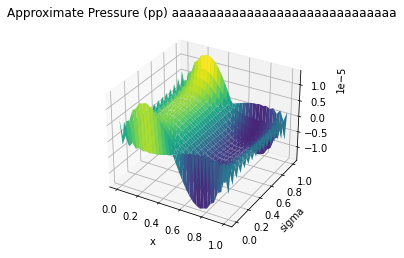

In [1766]:
def initialize_problem(domain_begin_array, domain_end_array, x_grid, sigma_grid):
    dx = np.abs((domain_end_array[0] - domain_begin_array[0]) / (x_grid - 1))
    dsigma = np.abs((domain_end_array[1] - domain_begin_array[1]) / (sigma_grid - 1))

    x = np.linspace(domain_begin_array[0], domain_end_array[0], x_grid)
    sigma = np.linspace(domain_begin_array[1], domain_end_array[1], sigma_grid)

    X, SIGMA = np.meshgrid(x, sigma)
    
    uu, uu_x, ww, ww_z, eta, etax, etaxx, pp = traveling_wave_1d(Hwave, cwave, kwave, SIGMA, hd, wwave, t, X)
    f = uu_x + ww_z
    u = np.zeros_like(f)  # Initial guess for u
    return dx, dsigma, X, SIGMA, u, f

def write_boundary_conditions(u):
    # Periodic in x
    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]

    # Neumann in sigma
    u[:, 0] = u[:,2]
    u[:, -1] = u[:,-3]   
    
    return u

def GS_iteration(dx, dy, p, f):
    x_dim, sigma_dim = p.shape
    p_xx = np.array([[0, 0, 0],
                     [1, -2, 1],
                     [0, 0, 0]]) / dx**2
    p_yy = np.array([[0, 1, 0],
                     [0, -2, 0],
                     [0, 1, 0]]) / dy**2

    combined = p_xx + p_yy/hd**2
    for i in range(1, x_dim-1):
        for j in range(1, sigma_dim-1):
            sum_of_stencil = np.sum(np.multiply(combined,p[i-1:i+2, j-1:j+2])) - combined[1, 1]*p[i, j]
            p[i, j] = (sum_of_stencil - f[i, j]) / combined[1, 1]
    return p

# Parameters
iterations = 500  # Number of iterations

# Initialize the problem
dx, dy, X, Y, p, f = initialize_problem(domain_begin_array, domain_end_array, x_grid, sigma_grid)
p = write_boundary_conditions(p)
for _ in range(iterations):
    p = GS_iteration(dx, dy ,p, f)
    p = write_boundary_conditions(p)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,p, cmap='viridis')
ax.set_title('Approximate Pressure (pp) aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
ax.set_xlabel('x')
ax.set_ylabel('sigma')
plt.show()

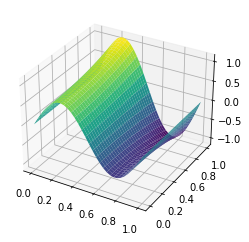

In [1767]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,f, cmap='viridis')